In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
import anndata
import scanpy as sc
import os
from sklearn.metrics import rand_score
import sys

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize = 15
plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [6]:
base = "/home/sina/projects/azucar/analysis/293T/obs1/out"

barcodes_fn = os.path.join(base, "map.txt.gz")
genes_fn = os.path.join(base, "genes.txt.gz")
mtx_fn = os.path.join(base, "matrix.mtx.gz")
t2g_fn = os.path.join("/home/sina/projects/azucar/reference/293T/cdna", "t2g.txt")

In [7]:
mtx = mmread(mtx_fn).tocsr()

In [8]:
gene = pd.read_csv(genes_fn, header = None, compression="gzip", names=["gid"])
bcs = pd.read_csv(barcodes_fn, compression="gzip", sep="\t")
bcs = bcs.set_index("bcs")

t2g = pd.read_csv(t2g_fn, 
                  header = None, 
                  names=["tid", "gid", "gene", "transcript", "chrom", "start", "stop", "strand"], 
                  sep="\t")
t2g = t2g.drop_duplicates("gid")
t2g = t2g.set_index("gid")

# map gene names to gene
gene["gene"] = gene.gid.map(t2g["gene"])

/home/sina/bin/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# TODO check why some ensgs are nans
t2g[t2g.isna().values]

,tid,gene,transcript,chrom,start,stop,strand
gid,,,,,,,
ENSG00000260179.1,ENST00000565563.1,NaN,NaN,1,1249777,1251334,-
ENSG00000260179.1,ENST00000565563.1,NaN,NaN,1,1249777,1251334,-
ENSG00000234396.3,ENST00000442483.2,NaN,NaN,1,2212523,2220738,+
ENSG00000234396.3,ENST00000442483.2,NaN,NaN,1,2212523,2220738,+
ENSG00000228037.1,ENST00000424215.1,NaN,NaN,1,2581560,2584533,+
...,...,...,...,...,...,...,...
ENSG00000271254.6,ENST00000612721.4,NaN,NaN,KI270711.1,6101,29626,-
ENSG00000268674.2,ENST00000601199.2,NaN,NaN,KI270713.1,35407,35916,+
ENSG00000268674.2,ENST00000601199.2,NaN,NaN,KI270713.1,35407,35916,+


In [10]:
adata = anndata.AnnData(X=mtx, obs=bcs, var=gene)
adata.layers["log1p"] = np.log1p(adata.X)

# TODO figure out why we have nan genes
adata = adata[:,adata.var.notna()["gene"]].copy()

# drop ribosomal and mitochondrial genes
dropgenes = np.logical_and(
    np.logical_and(
        ~adata.var.gene.str.upper().str.contains("RPL").values, 
        ~adata.var.gene.str.upper().str.startswith("MT-").values), 
    adata.var.gene.str.upper() != "MALAT1")
adata = adata[:,dropgenes].copy()

# drop the cells without assignments
adata = adata[adata.obs.notna()["assignments"]].copy()

adata

/home/sina/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1437 × 39592
    obs: 'assignment_ids', 'entropy', 'assignments', 'mahalanobis_0', 'mahalanobis_1', 'mahalanobis_2', 'mtag_1', 'mtag_2', 'mtag_3', 'mtag_4', 'dbco', 'dbco_bn'
    var: 'gid', 'gene'
    layers: 'log1p'

In [8]:
b = adata[adata.obs.eval("assignments == 'bic'").values].copy()
c = adata[adata.obs.eval("assignments == 'control'").values].copy()
t = adata[adata.obs.eval("assignments == 'tmg'").values].copy()
u = adata[adata.obs.eval("assignments == 'bic_tmg'").values].copy()

data = {
    "control": c, 
    "bic": b, 
    "tmg": t,
    "bic_tmg": u
}

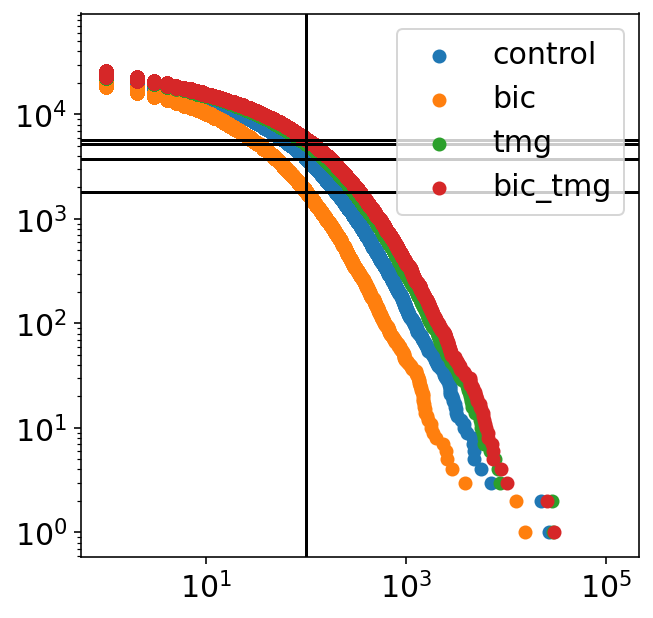

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ng = []
co = []
for label, a in data.items():
    x = np.sort(nd(a.X.sum(0)))[::-1]
    y = np.arange(x.shape[0])

    # if you return the entropy, you can pass it here as a color
    ax.scatter(x,y, label=label)

    cutoff = 100
    top_g = 1000
    ngenes = np.where(x>cutoff)[0][-1]
    ng_cutoff = x[:top_g][-1]
    co.append(ng_cutoff)
    ng.append(ngenes)
    ax.axvline(x=cutoff, color='k')
    ax.axhline(y=ngenes, color='k')

ax.set(**{
    "yscale" : "log",
    "xscale": "log"
})
ax.legend()
fig.show()

In [11]:
for idx, ((l, i), c) in enumerate(zip(data.items(), co)):
    data[l] = i[:,i.X.sum(0) > c].copy()
    data[l].layers["raw"] = data[l].X.copy()
    data[l].X = data[l].layers["log1p"].copy()

In [12]:
for idx, (l, i) in enumerate(data.items()):
    sc.pp.neighbors(data[l], use_rep="X")
    sc.tl.leiden(data[l])
    sc.tl.tsne(data[l], use_rep="X")

/home/sina/bin/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/sina/bin/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/sina/bin/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/sina/bin/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [13]:
for idx, (l, i) in enumerate(data.items()):
    print(i.obs.leiden.value_counts())

0    288
1    268
2    229
3    122
4     69
5      7
Name: leiden, dtype: int64
0    269
1    197
2    186
3     68
4     24
Name: leiden, dtype: int64
0    342
1    243
2    239
3    194
4    193
5     65
Name: leiden, dtype: int64
0    263
1    259
2    214
3    198
4    173
5     55
Name: leiden, dtype: int64


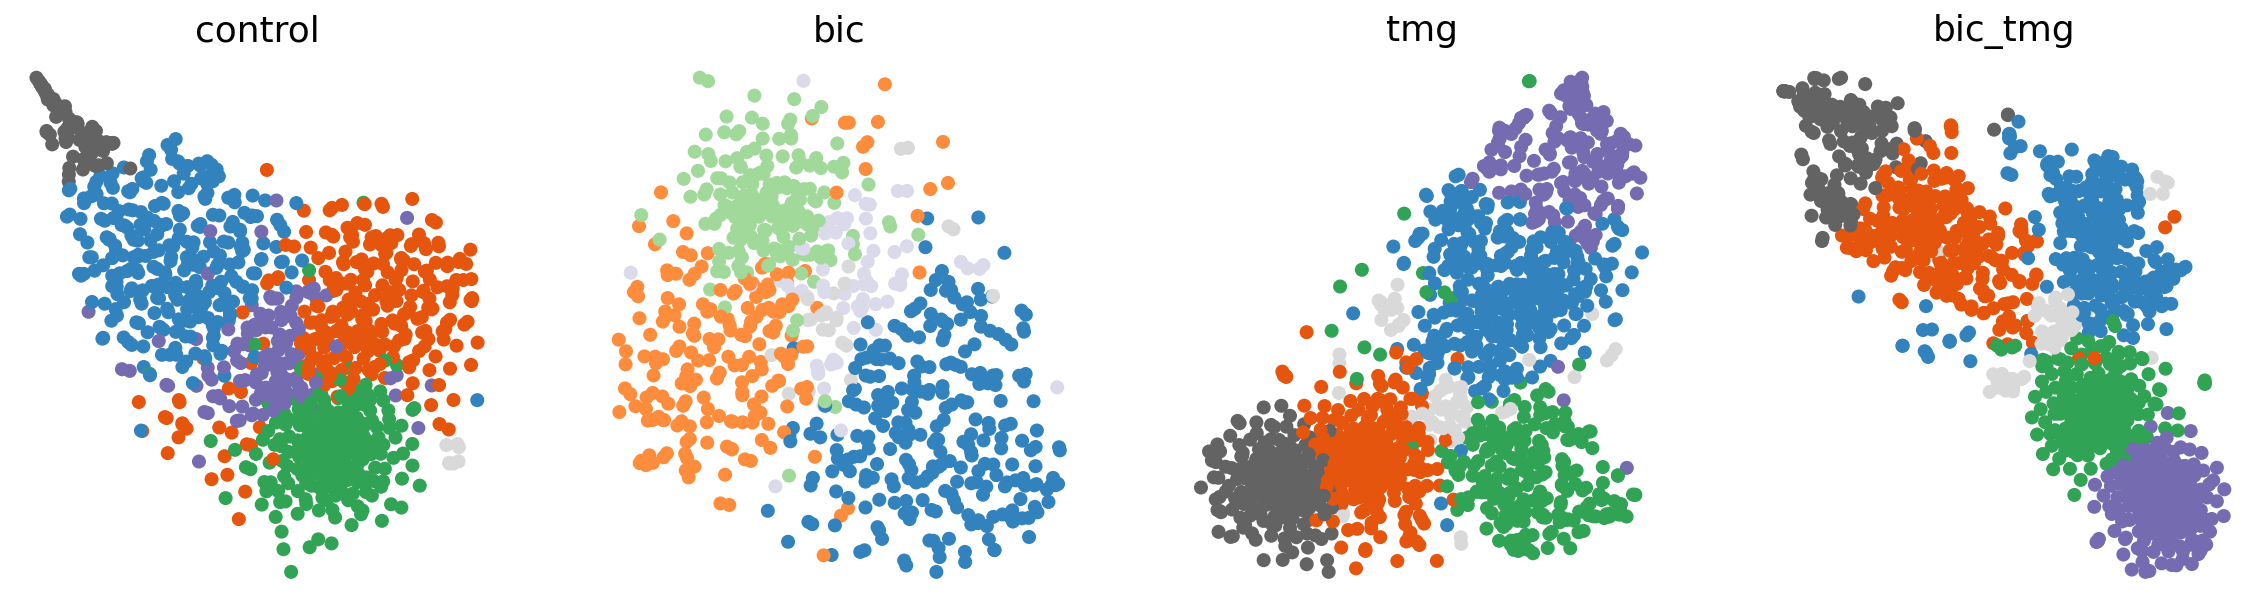

In [14]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=len(data.keys()))

for idx, ((l, i), ax) in enumerate(zip(data.items(), axs)):
    x = i.obsm["X_tsne"][:,0]
    y = i.obsm["X_tsne"][:,1]
    c = i.obs.leiden.values.astype(int)
    ax.scatter(x,y, c=c, cmap="tab20c")
    ax.set(**{
        "title": l
    })

    ax.set_axis_off()
fig.show()

In [15]:
#@title dexpress

from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import pandas as pd
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

import numpy as np
from statsmodels.stats.multitest import multipletests

def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, nfeat, method):
    if method == 'bonferroni':
        pval_corr = np.minimum(pval*nfeat[:,None], 1.0)
    return pval_corr

def nd(arr):
    return np.asarray(arr).reshape(-1)
def correct_pvals(pvals):
    r = np.empty(np.shape(pvals))
    r[:] = np.nan
    for pidx, p in enumerate(pvals):
        mask = ~np.isnan(p)


    return r


def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    es = np.empty((nuniq, nfeat)) # unique assignments by features 
    nfeatures = np.empty((nuniq))
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)
    es.fill(np.nan)
    nfeatures.fill(np.nan)
    

    for tidx, t in enumerate(unique):
        logging.info("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan
        effect_size = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
            effect_size = nd(t_mat.mean(axis=0)) - nd(c_mat.mean(axis=0))
            nfeatures[tidx] = mask.sum()
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
        es[tidx,:][mask] = effect_size
    return (pval, stat, es, nfeatures)

def make_table(assignments, features, p_raw, p_corr, es):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["gene", "p_raw", "p_corr", "es"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["gene"] = features
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["es"] = es[uidx]

    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    markers = markers.rename(columns={"index": "group_id"})
    return markers

In [16]:
%%time
dfs = {}
for idx, (label, i) in enumerate(data.items()):
    mat           = i.X.toarray() # this is log1p
    components    = i.obs.index.values
    features      = i.var.gene.values
    assignments   = i.obs.leiden.values


    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = correct_pval(p_raw, nfeat, corr_method)

    s = stat

    df = make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    df["p_corr"][df.eval("p_corr == 0").values] = sys.float_info.min
    df = df.query("es > 0").query("p_corr < 0.05")
    df["condition"] = label
    dfs[label] = df

09-Dec-21 15:36:05 - 1 of 6 assignments: 0
09-Dec-21 15:36:05 - 2 of 6 assignments: 1
09-Dec-21 15:36:05 - 3 of 6 assignments: 2
09-Dec-21 15:36:05 - 4 of 6 assignments: 3
09-Dec-21 15:36:05 - 5 of 6 assignments: 4
09-Dec-21 15:36:05 - 6 of 6 assignments: 5
09-Dec-21 15:36:05 - 1 of 5 assignments: 0
09-Dec-21 15:36:05 - 2 of 5 assignments: 1
09-Dec-21 15:36:05 - 3 of 5 assignments: 2
09-Dec-21 15:36:05 - 4 of 5 assignments: 3
09-Dec-21 15:36:05 - 5 of 5 assignments: 4
09-Dec-21 15:36:05 - 1 of 6 assignments: 0
09-Dec-21 15:36:05 - 2 of 6 assignments: 1
09-Dec-21 15:36:05 - 3 of 6 assignments: 2
09-Dec-21 15:36:05 - 4 of 6 assignments: 3
09-Dec-21 15:36:05 - 5 of 6 assignments: 4
09-Dec-21 15:36:05 - 6 of 6 assignments: 5
09-Dec-21 15:36:05 - 1 of 6 assignments: 0
09-Dec-21 15:36:05 - 2 of 6 assignments: 1
09-Dec-21 15:36:05 - 3 of 6 assignments: 2
09-Dec-21 15:36:05 - 4 of 6 assignments: 3
09-Dec-21 15:36:05 - 5 of 6 assignments: 4
09-Dec-21 15:36:05 - 6 of 6 assignments: 5


CPU times: user 155 ms, sys: 11.8 ms, total: 166 ms
Wall time: 158 ms


In [17]:
markers = pd.concat([i[1] for i in dfs.items()])

In [18]:
markers["condition_group"] = markers["condition"] + "." + markers["group_id"]

In [19]:
table = markers.groupby("condition_group")["gene"].apply(list)

In [20]:
markers

,group_id,gene,p_raw,p_corr,es,condition,condition_group
90,0,Syt1,0.000000,0.000000,0.569501,control,control.0
203,0,Ppp3r1,0.000000,0.000000,0.675600,control,control.0
233,0,Rtn1,0.000000,0.000000,0.626381,control,control.0
236,0,Gm19220,0.000000,0.000000,0.288399,control,control.0
243,0,Meg3,0.000000,0.000000,0.738558,control,control.0
...,...,...,...,...,...,...,...
4972,4,Ids,0.000000,0.000000,0.878986,bic_tmg,bic_tmg.4
4978,4,Tspan7,0.000000,0.000000,0.884193,bic_tmg,bic_tmg.4
5479,5,Celf2,0.000759,0.008349,0.314295,bic_tmg,bic_tmg.5
5584,5,Ppp3ca,0.000000,0.000000,0.783495,bic_tmg,bic_tmg.5


In [21]:
table

condition_group
bic.0        [Syt1, Ppp3r1, Rtn1, Gm19220, Meg3, Gm26822, R...
bic.1                    [Meg3, Rn18s, Snhg11, Mir6236, Lars2]
bic.4                                                 [Ppp3ca]
bic_tmg.0    [Syt1, Psap, Lsm12, Dynll2, Ppp3r1, Calm1, Rtn...
bic_tmg.1    [Itm2c, Atp2b1, Syt1, Psap, Ppp3r1, Calm1, Rtn...
bic_tmg.3                                     [Atp1a2, Slc1a2]
bic_tmg.4    [Zbtb18, Hnrnpu, Ap1s3, Itm2c, R3hdm1, Gm37357...
bic_tmg.5                                [Celf2, Ppp3ca, Nrgn]
control.0    [Syt1, Ppp3r1, Rtn1, Gm19220, Meg3, App, Rn18s...
control.1                         [Meg3, Rn18s, Snhg11, Lars2]
control.3                                               [Nrgn]
control.4    [Hnrnpu, Ap1s3, Gls, Itm2c, Gm37357, Dst, Atp1...
control.5                             [Hba-a1, Hba-a2, Hbb-bs]
tmg.0        [Itm2c, Atp2b1, Syt1, Psap, Ppp3r1, Calm1, Rtn...
tmg.2        [Syt1, Lsm12, Rtn1, Gm19220, Meg3, Rian, Gm268...
tmg.3        [Zbtb18, Hnrnpu, Ap1s3, It

In [22]:
def violinplot(data, ax, **kwd):
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    c = kwd.get("c", [])

    if len(xticks) == 0:
        xticks = np.arange(len(data)) + 1
    if len(xticklabels) == 0:
        xticklabels = np.arange(len(data)) + 1
    assert len(xticks) == len(xticklabels)

    violins = ax.violinplot(
        data, positions=xticks, showmeans=False, showmedians=False, showextrema=False
    )

    for vidx, v in enumerate(violins["bodies"]):
        v.set_facecolor(color)
        v.set_edgecolor("black")
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))

#         # actual points
#         argsort = np.argsort(c[didx])
#         dd = d[argsort]
#         cc = c[didx][argsort]
#         ax.scatter(xx, dd, s=5, c=cc)
        ax.scatter(xx, d, s=5)
        im = ax

        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(
            x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10
        )
        ax.vlines(
            x,
            mean - stdev,
            mean + stdev,
            color="lightgrey",
            linestyle="-",
            lw=2,
            zorder=9,
        )

    ax.set(**{"xticks": xticks, "xticklabels": xticklabels})

    return im

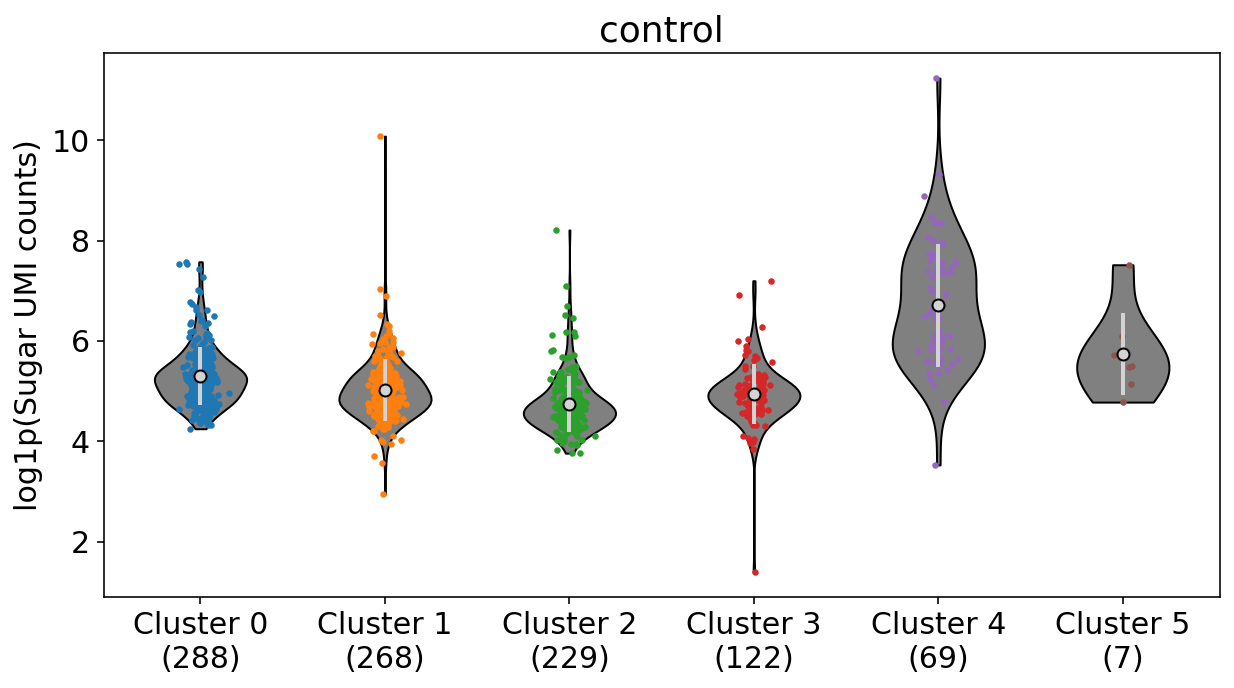

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

condition = "control"
col = "dbco"
color_col = "entropy"
e = 0.0001

assignments = np.unique(data[condition].obs.leiden.values)

plot = {a: data[condition].obs.query(f"leiden == '{a}'") for a in assignments}

x = [np.log1p(v[col]) for _,v in plot.items()]

# color = [v[color_col].values for _,v in plot.items()]

xticklabels = [f"Cluster {k}\n({v.shape[0]:,.0f})" for k,v in plot.items()]
im = violinplot(x, ax=ax, xticklabels=xticklabels)

ax.set(**{
    "ylabel": "log1p(Sugar UMI counts)",
    "title": f"{condition}"
})

fig.show()

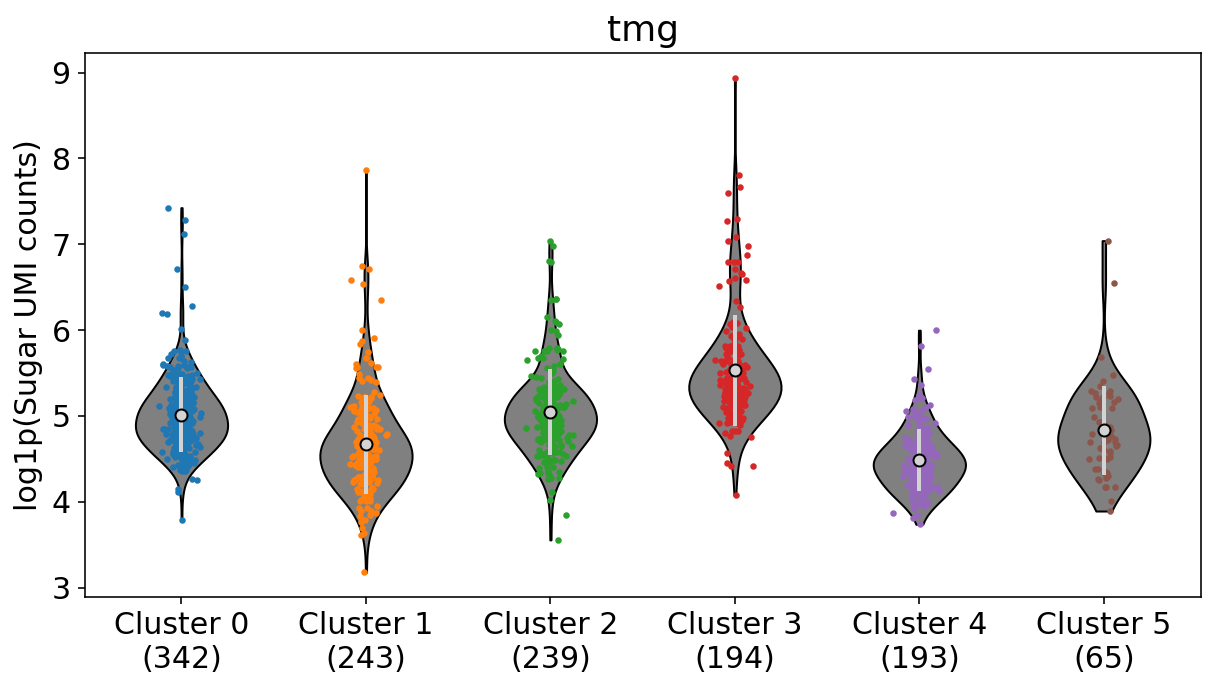

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

condition = "tmg"
col = "dbco"
color_col = "entropy"
e = 0.0001

assignments = np.unique(data[condition].obs.leiden.values)

plot = {a: data[condition].obs.query(f"leiden == '{a}'") for a in assignments}

x = [np.log1p(v[col]) for _,v in plot.items()]

# color = [v[color_col].values for _,v in plot.items()]

xticklabels = [f"Cluster {k}\n({v.shape[0]:,.0f})" for k,v in plot.items()]
im = violinplot(x, ax=ax, xticklabels=xticklabels)

ax.set(**{
    "ylabel": "log1p(Sugar UMI counts)",
    "title": f"{condition}"
})

fig.show()

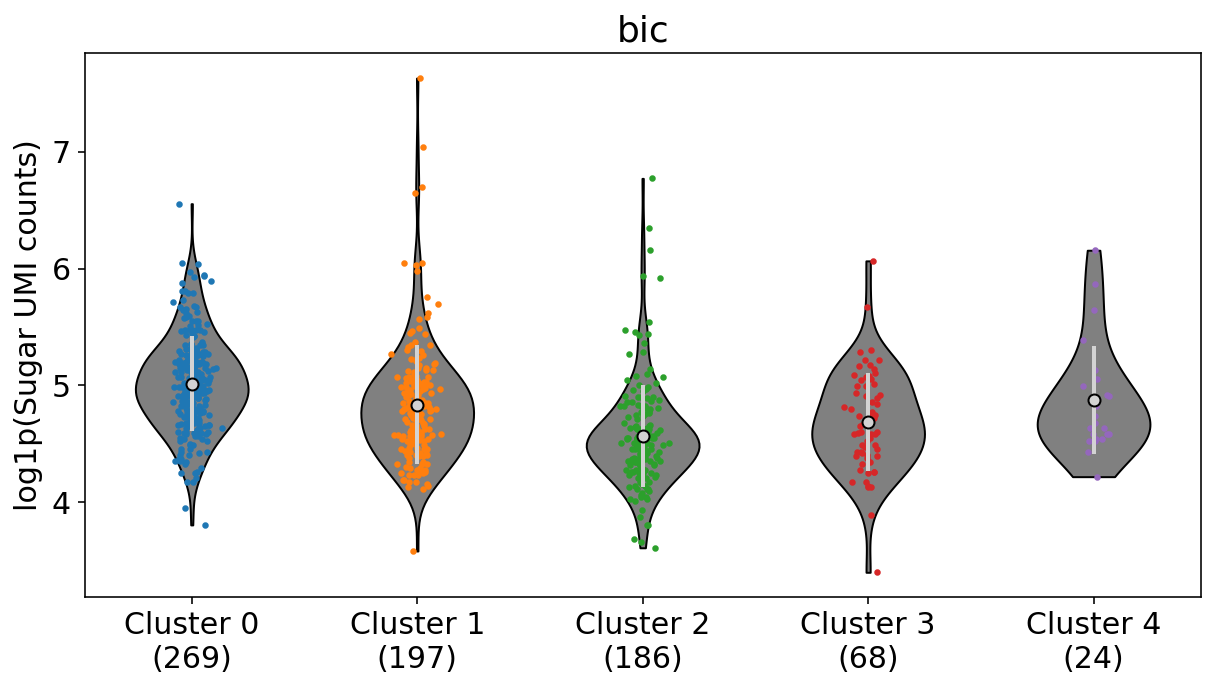

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

condition = "bic"
col = "dbco"
color_col = "entropy"
e = 0.0001

assignments = np.unique(data[condition].obs.leiden.values)

plot = {a: data[condition].obs.query(f"leiden == '{a}'") for a in assignments}

x = [np.log1p(v[col]) for _,v in plot.items()]

# color = [v[color_col].values for _,v in plot.items()]

xticklabels = [f"Cluster {k}\n({v.shape[0]:,.0f})" for k,v in plot.items()]
im = violinplot(x, ax=ax, xticklabels=xticklabels)

ax.set(**{
    "ylabel": "log1p(Sugar UMI counts)",
    "title": f"{condition}"
})

fig.show()

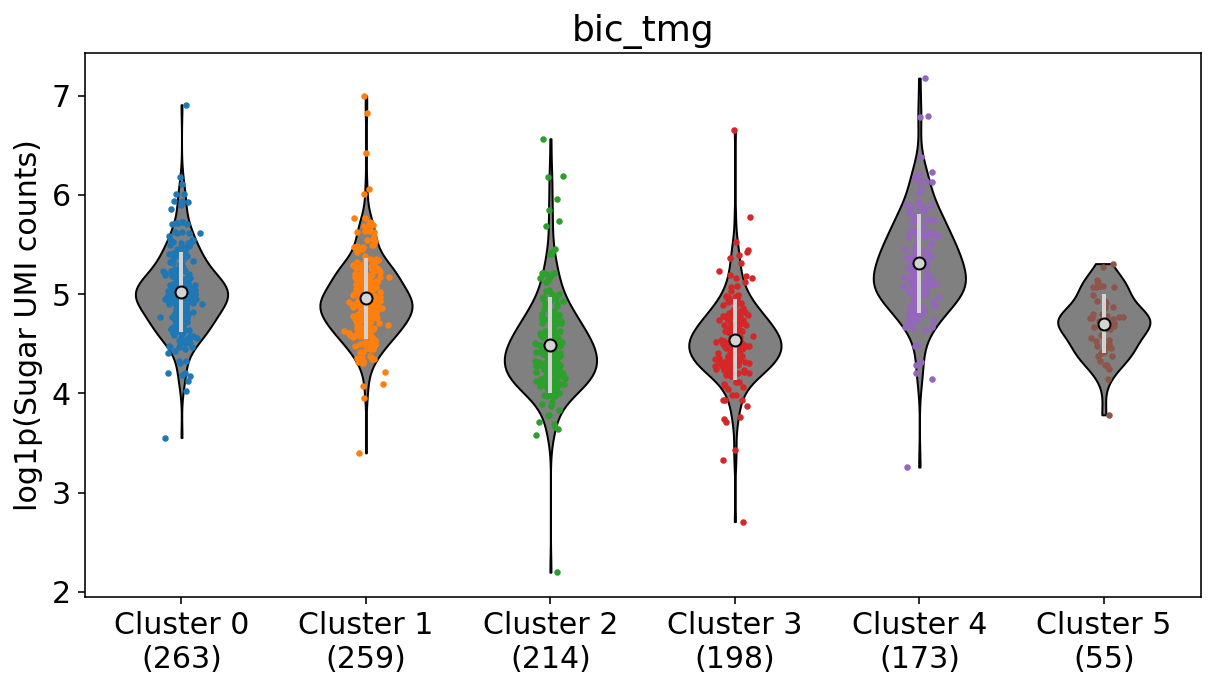

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

condition = "bic_tmg"
col = "dbco"
color_col = "entropy"
e = 0.0001

assignments = np.unique(data[condition].obs.leiden.values)

plot = {a: data[condition].obs.query(f"leiden == '{a}'") for a in assignments}

x = [np.log1p(v[col]) for _,v in plot.items()]

# color = [v[color_col].values for _,v in plot.items()]

xticklabels = [f"Cluster {k}\n({v.shape[0]:,.0f})" for k,v in plot.items()]
im = violinplot(x, ax=ax, xticklabels=xticklabels)

ax.set(**{
    "ylabel": "log1p(Sugar UMI counts)",
    "title": f"{condition}"
})

fig.show()

In [28]:
blah = ['control.4', 'tmg.3', 'bic.0', 'bic_tmg.4']

In [29]:
markers.query(f"condition_group == '{blah[0]}'").sort_values('es', ascending=False).head()

,group_id,gene,p_raw,p_corr,es,condition,condition_group
4227,4,Meg3,0.0,0.0,1.997346,control,control.4
4893,4,Nrgn,0.0,0.0,1.874302,control,control.4
4074,4,Syt1,0.0,0.0,1.869739,control,control.4
4815,4,Slc17a7,0.0,0.0,1.857960,control,control.4
4588,4,Ppp3ca,0.0,0.0,1.837706,control,control.4


In [30]:
markers.query(f"condition_group == '{blah[1]}'").sort_values('es').head()

,group_id,gene,p_raw,p_corr,es,condition,condition_group
3144,3,Lsm12,0.0,0.0,0.528716,tmg,tmg.3
3201,3,Tug1,0.0,0.0,0.621005,tmg,tmg.3
2998,3,Ap1s3,0.0,0.0,0.630271,tmg,tmg.3
3279,3,Mycbp2,0.0,0.0,0.651384,tmg,tmg.3
3022,3,Gm37357,0.0,0.0,0.680568,tmg,tmg.3


In [31]:
markers.query(f"condition_group == '{blah[2]}'").sort_values('es').head()

,group_id,gene,p_raw,p_corr,es,condition,condition_group
393,0,Gm26822,0.0,0.0,0.421657,bic,bic.0
234,0,Gm19220,0.0,0.0,0.503849,bic,bic.0
739,0,Actb,0.0,0.0,0.570418,bic,bic.0
529,0,Snhg11,0.0,0.0,0.583721,bic,bic.0
577,0,Celf1,0.0,0.0,0.666445,bic,bic.0


In [32]:
markers.query(f"condition_group == '{blah[3]}'").sort_values('es').head()

,group_id,gene,p_raw,p_corr,es,condition,condition_group
4138,4,Lsm12,0.0,0.000001,0.350176,bic_tmg,bic_tmg.4
4346,4,Zbtb20,0.0,0.000000,0.396577,bic_tmg,bic_tmg.4
4194,4,Tug1,0.0,0.000000,0.569299,bic_tmg,bic_tmg.4
4221,4,Rbm25,0.0,0.000000,0.648536,bic_tmg,bic_tmg.4
4021,4,Gm37357,0.0,0.000000,0.681143,bic_tmg,bic_tmg.4


In [34]:
np.intersect1d(
    np.intersect1d(
        np.intersect1d(
            markers.query(f"condition_group == '{blah[0]}'").gene.values, 
            markers.query(f"condition_group == '{blah[1]}'").gene.values),
        markers.query(f"condition_group == '{blah[2]}'").gene.values), 
    markers.query(f"condition_group == '{blah[3]}'").gene.values)

array(['Actb', 'Celf1', 'Celf2', 'Gm19220', 'Gm26822', 'Grin2b', 'Lars2',
       'Meg3', 'Mir6236', 'Nrgn', 'Ppp3ca', 'Ppp3r1', 'Rn18s', 'Rtn1',
       'Slc17a7', 'Snap25', 'Snhg11', 'Syt1'], dtype=object)

In [35]:
from sklearn import linear_model

lasso = linear_model.Lasso(
    max_iter=10000, 
    alpha=0.1, 
    fit_intercept=False)

In [36]:
for l, i in data.items():
    lasso.fit(i.layers["log1p"], np.log1p(i.obs.dbco.values))
    data[l].var["lasso_coef"] = lasso.coef_

In [37]:
for l, i in data.items():
    print(l, i.var[i.var.lasso_coef > 0].gene.values)

control ['Atp1a2' 'Rn18s' 'Gm10800' 'Actb']
bic ['Atp1a2' 'Rn18s']
tmg ['Atp1a2' 'Rn18s' 'Slc1a2']
bic_tmg ['Atp1a2' 'Rn18s' 'Slc1a2']


In [46]:
condition = "control"
gene = "Slc1a2"

In [49]:
from scipy import stats

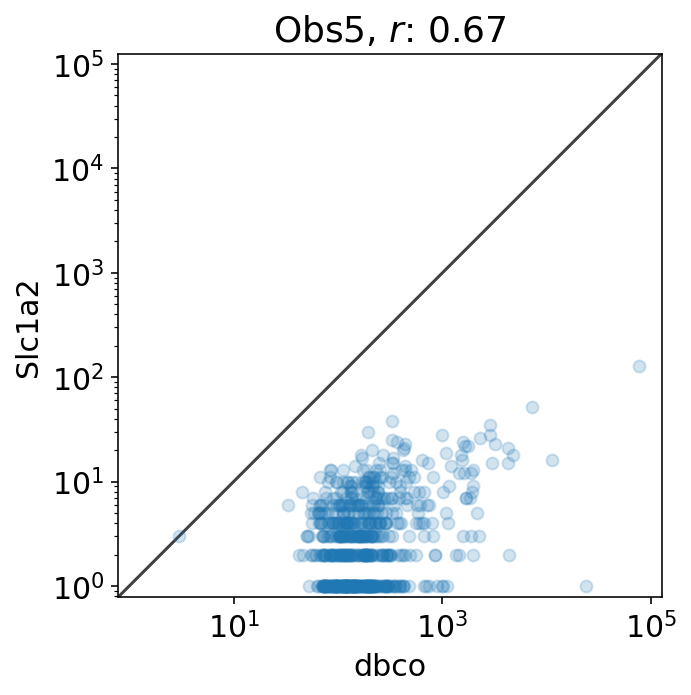

In [51]:
fig, ax = plt.subplots(figsize=(5,5))

x = data[condition].obs["dbco"].values
genemask = data[condition].var.gene.values == gene
y = data[condition].layers["raw"][:,genemask].toarray()

r, p = stats.pearsonr(x,nd(y))

ax.scatter(x,y, alpha=0.2)

ax.set(**{
    "xlabel": "dbco", 
    "ylabel": f"{gene}",
    "xscale": "log",
    "yscale": "log",
    "title": f"Obs5, $r$: {r:,.2f}"
})
yex(ax)

fig.show()

In [11]:
table = adata.obs.query("entropy < 0.01").groupby("assignments")[["mtag_1", "mtag_2","mtag_3","mtag_4","dbco"]].apply(np.sum).T.astype(int)

In [12]:
table

assignments,control,no_sugar,tmg
mtag_1,16238,79505,16378
mtag_2,6213,2404,51750
mtag_3,140078,125535,240109
mtag_4,208492,5518,6638
dbco,11515,4017,18162


In [13]:
from ipfn import ipfn

In [24]:
rows, cols = table.shape
n = 1
aggregates = [nd(table.values.sum(1))/table.values.sum(1).sum(), np.ones(cols)*n/cols]
dimensions = [[0], [1]]

In [27]:
aggregates

[array([0.12023029, 0.06473312, 0.54229898, 0.23660664, 0.03613096]),
 array([0.33333333, 0.33333333, 0.33333333])]

In [28]:
IPF = ipfn.ipfn(table.values, aggregates, dimensions, max_iteration=1000)
m = IPF.iteration()

In [29]:
table

assignments,control,no_sugar,tmg
mtag_1,16238,79505,16378
mtag_2,6213,2404,51750
mtag_3,140078,125535,240109
mtag_4,208492,5518,6638
dbco,11515,4017,18162


In [32]:
pd.DataFrame(m*table.values.sum(), index=["mtag_1","mtag_2","mtag_3","mtag_4","dbco"], columns=[
    "control",
    "no_sugar",
    "tmg"
]).astype(int)

,control,no_sugar,tmg
mtag_1,7955,92842,11323
mtag_2,4414,4070,51882
mtag_3,91039,194469,220214
mtag_4,199137,12562,8946
dbco,8304,6905,18484


In [71]:
m.sum()

1.0